# 概要

アダブーストは、非常に簡単なベース分類器で構成される。
この弱学習機は、当て推量をわずかに上回る程度である。<br>
アダブーストなどのブースティングのアルゴリズムはバリアンスが高いことでも知られている<br>


手順は下記のとおり。<br>
1.トレーニングデータセットDからランダムなサブセット$d_1$を非復元抽出し弱学習機$C_1$1をトレーニングする<br>
2.2つ目のランダムなトレーニングセット$d_2$をトレーニングデータセットから非復元抽出し、<br>
  以前に誤分類されたサンプルの50%を追加して、弱分類器$C_2$をトレーニングする<br>
3.トレーニングデータセットDから$c_1$と$C_2$の結果が異なるトレーニングサンプル$d_3$を洗い出し、3つ目の弱分類器$C_3$をトレーニングする<br>
4.弱分類器$C_1$,$C_2$,$C_3$を多数決により組み合わせる

アダブーストは、以前誤分類となったデータの重みを増やしながら学習を行う。<br>
例えば下図のようになる（図形が大きいほどそのデータの重みが増やしているということ）<br>

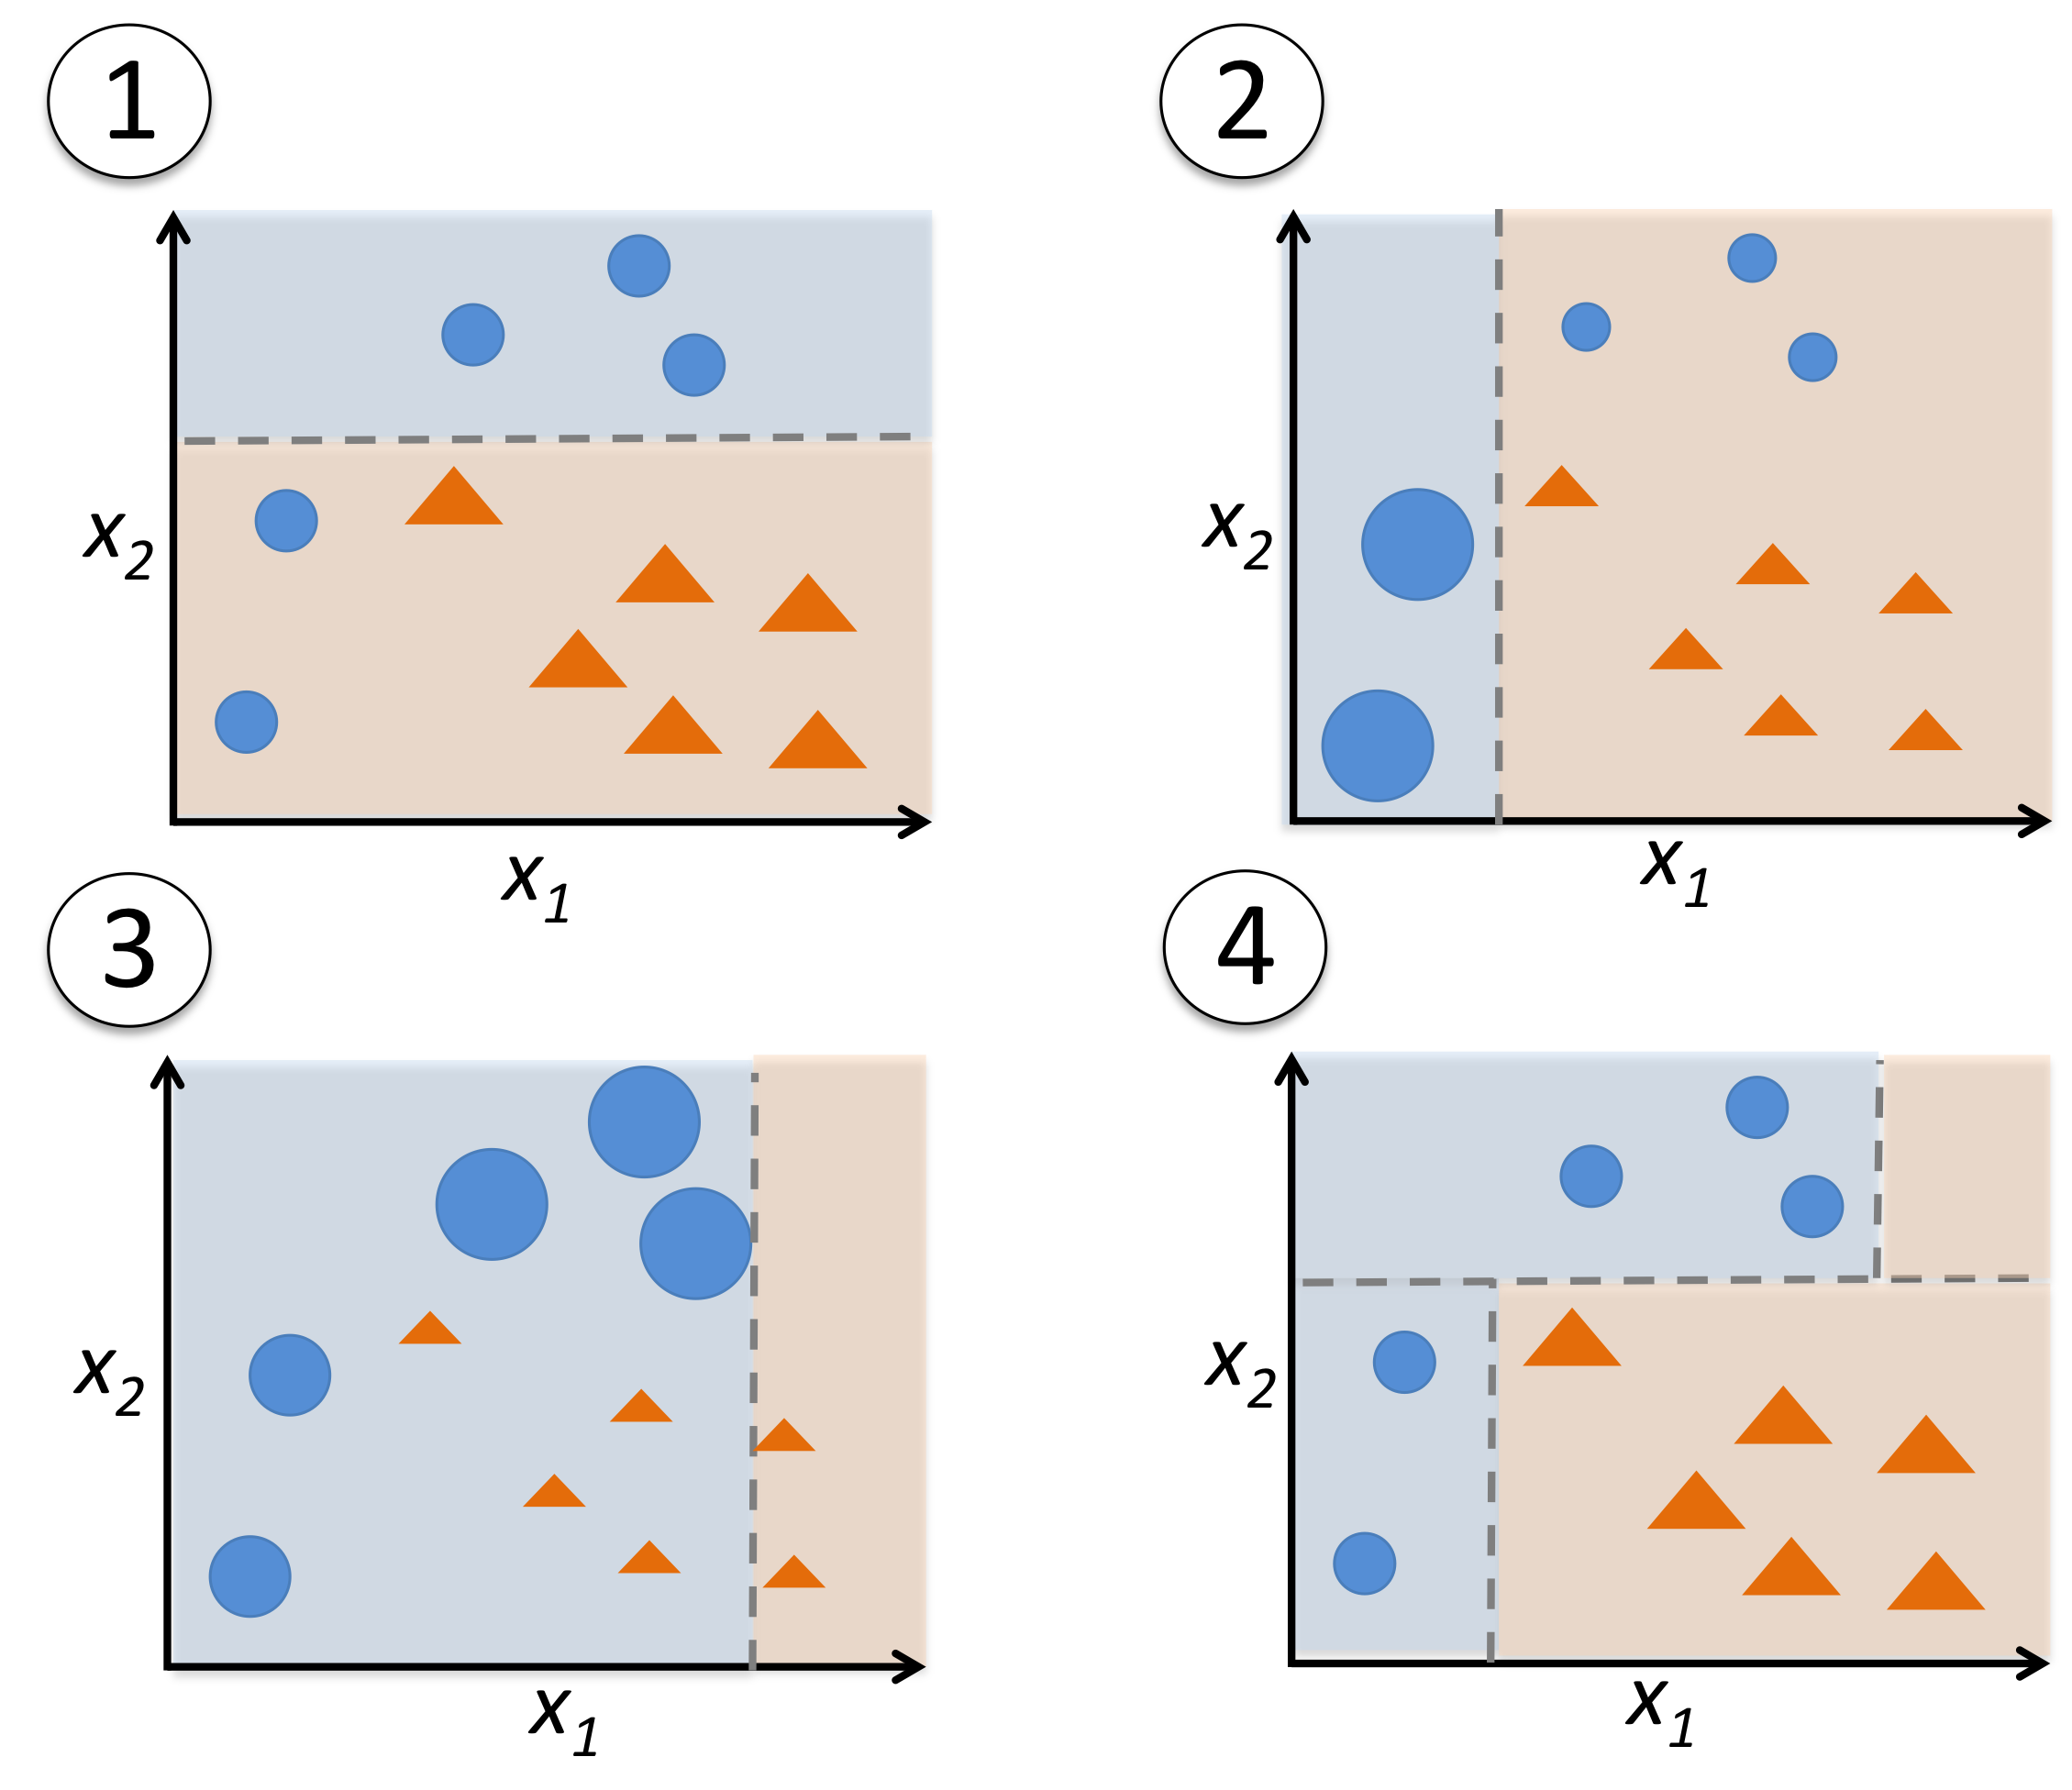

In [2]:
from IPython.display import Image
Image(filename='./images/07_09.png', width=500) 

# 実装

In [4]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=0)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=0)

In [10]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (ada_train, ada_test))

Decision tree train/test accuracies 0.845/0.854
AdaBoost train/test accuracies 1.000/0.875


上記より、AdaBoostを使う前の決定器は学習不足であったがAdaBoostはそれは解消されている

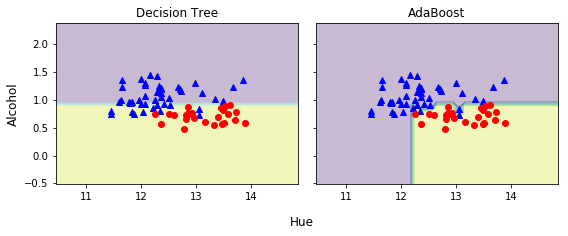

In [13]:
import numpy as np
import matplotlib.pyplot as plt

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision Tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='red', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2,
         s='Hue',
         ha='center', va='center', fontsize=12)

plt.tight_layout()
# plt.savefig('./figures/adaboost_region.png',
#           dpi=300,
#           bbox_inches='tight')
plt.show()

# その他の関数

In [6]:
# Added version checak for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

In [7]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values

In [8]:
from sklearn.preprocessing import LabelEncoder
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split


le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y, 
                             test_size=0.40, 
                             random_state=1)